In [1]:
cifar_dir = 'cifar-10-batches-py/'

In [2]:
def unpickle(file):
    import pickle
    with open(file,'rb') as f:
        cifar_dict = pickle.load(f,encoding='bytes')
     
    return cifar_dict

In [3]:
dirs = ['batches.meta','data_batch_1','data_batch_2','test_batch','data_batch_4','data_batch_5','test_batch']

In [4]:
all_data = [0,1,2,3]

In [5]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(cifar_dir+direc)

In [6]:
batches_meta = all_data[0]
data_batch_1 = all_data[1]
data_batch_2 = all_data[2]
#data_batch_3 = all_data[3]
#data_batch_4 = all_data[4]
#data_batch_5 = all_data[5]
test_batch = all_data[3]

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [8]:
X = data_batch_1[b'data']
X = X.reshape(10000,3,32,32).transpose(0,2,3,1).astype("uint8")

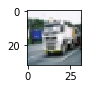

In [9]:
plt.figure(figsize=(1,1))
plt.imshow(X[1000])

In [10]:
class Cifar_model():
    def __init__(self):
        self.i = 0
        self.training_images = None
        self.training_labels = None
        self.data_batches = [data_batch_1,data_batch_2,data_batch_3,data_batch_4,data_batch_5]
        self.test_images = None
        self.test_labels = None
        self.test_batch = [test_batch]
       
    
    def set_up_images(self):
        print("Setting up training images and labels")
        self.training_images = np.vstack(d[b'data'] for d in self.data_batches)
        self.training_labels = one_hot_encode(np.hstack(d[b'labels'] for d in self.data_batches),10)
        training_len = len(self.training_images)
        self.training_images = self.training_images.reshape(training_len,3,32,32).transpose(0,2,3,1)/255
        
        
        print("Setting up testing images and labels")
        self.test_images = np.vstack(d[b'data'] for d in self.test_batch)
        self.test_labels = one_hot_encode(np.hstack(d[b'labels'] for d in self.test_batch),10)
        testing_len = len(self.test_images)
        self.test_images = self.test_images.reshape(testing_len,3,32,32).transpose(0,2,3,1)/255
        
       
    def next_batch(self,batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(batch_size,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x,y

In [11]:
def one_hot_encode(vec,vals):
    n = len(vec)
    out = np.zeros((n,vals))
    out[range(n),vec] = 1
    return out

In [12]:
ch = Cifar_model()
ch.set_up_images()

NameError: name 'data_batch_3' is not defined

In [ ]:
import tensorflow as tf

In [ ]:
x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,10])
hold_prob = tf.placeholder(tf.float32)

In [ ]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [ ]:
conv_1 = convolutional_layer(x,shape=[4,4,3,32])
conv_1_pool = max_pool_2by2(conv_1)

In [ ]:
conv_2 = convolutional_layer(conv_1_pool,shape=[4,4,32,64])
conv_2_pool = max_pool_2by2(conv_2)

In [ ]:
'''
conv_3 = convolutional_layer(conv_2_pool,shape=[2,2,32,64])
conv_3_pool = max_pool_2by2(conv_3)
conv_3_drop=tf.nn.dropout(conv_3_pool,keep_prob=hold_prob)

conv_3_drop.get_shape().as_list()
'''

In [ ]:
conv_2_flat = tf.reshape(conv_2_pool,[-1,8*8*64])#tf.reshape(conv_3_pool,[-1,1024])


In [ ]:
affine_layer_1 = tf.nn.relu(normal_full_layer(conv_2_flat,128))
affine_layer_1.get_shape().as_list()

In [ ]:
'''
affine_layer_2 = tf.nn.relu(normal_full_layer(affine_layer_1,128))
affine_layer_2.get_shape().as_list()
'''

In [ ]:
drop_out = tf.nn.dropout(affine_layer_1,keep_prob=hold_prob)

In [ ]:
y_pred = normal_full_layer(drop_out,10)

In [ ]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))

In [ ]:
optim = tf.train.AdamOptimizer(learning_rate=0.001)

In [ ]:
train = optim.minimize(cross_entropy)

In [ ]:
init = tf.global_variables_initializer()

In [ ]:
saver = tf.train.Saver()

In [ ]:
epochs = 2
batch_size = 100
ch.training_images.shape[0]

In [ ]:
with tf.Session() as sess:
    sess.run(init)
    num_batches = ch.training_images.shape[0] // batch_size
    for epoch in range(epochs):
        
        for i in range(num_batches):
            batch = ch.next_batch(batch_size)
            sess.run(train, feed_dict={x:batch[0],y_true:batch[1],hold_prob:0.25})
       
            if i%100 == 0:
                print("Currently on step : {}".format(i))
                print("Accuracy is :")
                matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
                #matches = [True,False,True,True,.......]
                acc = tf.reduce_mean(tf.cast(matches,tf.float32))
                print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0}))
                print("\n")
       
    saver.save(sess,"./cifar_10_train_model")

In [ ]:
import tensorflow as tf
import cv2
test_path = 'test1.jpeg'
test_image1 = cv2.imread(test_path)
test_image1=cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB)

In [ ]:

with tf.Session() as sess:
    sess = tf.train.Saver().restore("./cifar_10_train_model")
    pred = sess.run(y_pred,feed_dict={x:test_image1,hold_prob:1.0})
   
    